Here's a short introduction/instruction you can use for your assignment in Colab:

---

# Introduction

Welcome to this Colab Notebook! This notebook is designed to guide you through the [specific task or topic] using Python. It's a self-contained interactive environment where you can run code cells and explore the concepts hands-on.

## Instructions

1. **Run Each Code Cell Sequentially**: Click on the code cells (blocks of code) and press the play button or press `Shift + Enter` to execute the code. Make sure to run the cells in the given order for the best results.

2. **Modify and Experiment**: Feel free to modify the code to test different scenarios or improve your understanding. Colab allows you to experiment with the code directly in the notebook.

3. **Use Provided Comments**: Throughout the notebook, you'll find comments and explanations that guide you through the process and help you understand the logic behind the code.

4. **Save Your Progress**: If you want to save your changes or notes, you can download the notebook or save it directly to your Google Drive.

## Prerequisites

- **Basic Python Knowledge**: You should have a basic understanding of Python, including functions, loops, and variables.
- **Colab Basics**: Familiarity with the Google Colab environment is recommended but not required.

Feel free to reach out if you have any questions!

# Introduction to the Kalman Filter & Extended Kalman filter (EKF) with Python Code

The Kalman Filter is an algorithm that fuses noisy sensor measurements to produce estimates of unknown variables that tend to be more accurate than those based on a single measurement alone. It's widely used in control systems, navigation, and signal processing.

In this tutorial, we'll introduce the Kalman Filter conceptually and implement a simple Kalman Filter in Python. We'll step through the code to understand how each part contributes to the filter's functionality.


## Table of Contents

- [1. Example1 :Estimating Object Weight Using a Kalman Filter Class](#Example1)
- [2. Exercise 1: Implementing a Kalman Filter for Temperature Sensor Fusion](#2-Exercise1)
- [3. Exersice 2: 1D Position and Velocity Estimation Using Kalman Filter in Uniform Linear Motion](#3-Exersice2)
- [4. Exersice 3: Kalman Filter Application on a 2D Nonlinear Motion Trajectory](#4-Exersice3)
- [5. Example2: Introduction to the Extended Kalman Filter (EKF)](#5-Example2)
- [6. Exercise 4: Implementing an Extended Kalman Filter (EKF) for Robot Localization](#4-Exersice4)



# Example1 :Estimating Object Weight Using a Kalman Filter Class
## Introduction
When measuring the weight of an object using a scale, readings can be affected by various sources of noise and uncertainty, such as sensor inaccuracies, environmental factors, and mechanical vibrations. The Kalman filter is a powerful tool that helps produce a more accurate estimate by considering the statistical properties of the noise and the system dynamics.

In this experiment, we will:

- Implement the Kalman filter as a class in Python.
- Estimate the measurement and process noise covariances from the measurements.
- Use the Kalman filter class to estimate the true weight of an object from noisy measurements.
- Analyze the results and discuss the importance of accurate noise covariance estimation.

This notebook is designed for educational purposes, to help students understand how to implement and use the Kalman filter in practice.

## Experiment Overview
Objective: Estimate the true weight of an object using noisy scale measurements by applying the Kalman filter implemented as a class.
Approach:
- Simulate noisy measurements of the object's weight.
- Estimate the measurement noise covariance $𝑅$ from the measurements.
- Estimate the process noise covariance $Q$ based on system dynamics.
Define a Kalman filter class.
- Use the Kalman filter class to process the measurements.
- Analyze the results and compute performance metrics.
Let's proceed with the implementation.



## Import Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Simulate True Weight and Measurements
We will generate synthetic data that mimics real-world measurements.

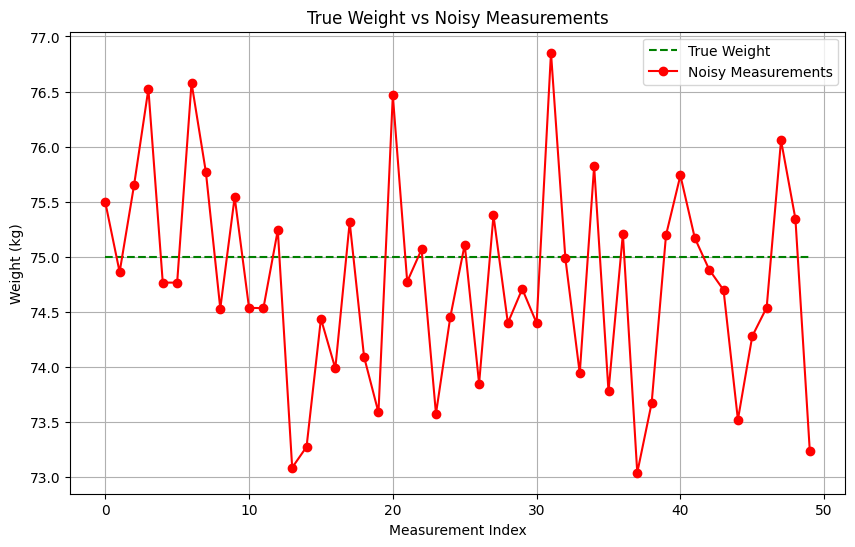

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of measurements
num_measurements = 50

# True weight of the object (in kilograms)
true_weight = 75.0

# Generate true weight over time (assuming it's constant)
true_weights = np.full(num_measurements, true_weight)

# Simulate measurement noise (unknown in real life)
measurement_noise_std_true = 1.0  # This is unknown in practice
measurement_noise = np.random.normal(0, measurement_noise_std_true, size=num_measurements)

# Simulate process noise (unknown in real life)
process_noise_std_true = 0.05  # This is unknown in practice
process_noise = np.random.normal(0, process_noise_std_true, size=num_measurements)

# Generate noisy measurements
measurements = true_weights + measurement_noise

# Visualization
plt.figure(figsize=(10, 6))

# Plot true weights
plt.plot(true_weights, label='True Weight', linestyle='--', color='g')

# Plot noisy measurements
plt.plot(measurements, label='Noisy Measurements', linestyle='-', color='r', marker='o')

# Labels and title
plt.xlabel('Measurement Index')
plt.ylabel('Weight (kg)')
plt.title('True Weight vs Noisy Measurements')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

**Note**: In a real-life scenario, we would only have access to the measurements, not the true noise standard deviations

## Estimating Noise Covariances from Measurements

### Estimating Measurement Noise Covariance $R$

Since we cannot directly measure the measurement noise, we can estimate its covariance by analyzing the variability in the measurements.

### Using the Method of Successive Differences

We can use the differences between consecutive measurements to estimate the measurement noise variance.

$$
R \approx \frac{{\text{Var}(\Delta z)}}{2}
$$


In [ ]:
# Compute differences between consecutive measurements
delta_measurements = np.diff(measurements)

# Estimate the variance of the measurement noise
variance_delta_measurements = np.var(delta_measurements, ddof=1)

# Estimate measurement noise covariance R
R_estimated = variance_delta_measurements / 2

print(f"Estimated Measurement Noise Covariance (R): {R_estimated:.4f} kg^2")


Estimated Measurement Noise Covariance (R): 0.8338 kg^2


### Estimating Process Noise Covariance $Q$
The process noise represents the uncertainty in the system model. Since the weight is assumed to be nearly constant, we can set $Q$to a small value.

In [ ]:
# Since we don't know the true process noise, we'll make an educated guess
process_variation_estimate = 0.1  # Expected standard deviation of weight changes
Q_estimated = process_variation_estimate ** 2

print(f"Estimated Process Noise Covariance (Q): {Q_estimated:.6f} kg^2")

Estimated Process Noise Covariance (Q): 0.010000 kg^2


## Define the Kalman Filter Class



We will create a `KalmanFilter` class that encapsulates the Kalman filter logic.

### Kalman Filter Equations

The Kalman filter consists of two main steps at each time step $k$:

1. **Prediction Step**:
    - Predict the state estimate:
$$
\hat{x}_{k|k-1} = F \hat{x}_{k-1|k-1}
$$
    - Predict the estimation error covariance:
    $$
    P_{k|k-1} = F P_{k-1|k-1} F^{T} + Q
    $$

2. **Update Step**:
    - Compute the Kalman Gain:
$$
K_k = P_{k|k-1} H^{T} (H P_{k|k-1} H^{T} + R)^{-1}
$$
    - Update the state estimate with the measurement $z_k$ :
  $$
  \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1})
  $$
    - Update the estimation error covariance:
    $$
    P_{k|k} = (I - K_k H) P_{k|k-1}
    $$

3. **Variables Explanation:**

- $\hat{x}_{k|k-1}$: Predicted state estimate at time \(k\) given observations up to \(k-1\).
- $\hat{x}_{k|k}$: Updated state estimate at time \(k\) after including the measurement at \(k\).
- $P_{k|k-1}$: Predicted error covariance.
- $P_{k|k}$: Updated error covariance.
- $F_k$: State transition model.
- $u_k$: Control vector.
- $Q$: Process noise covariance.
- $H_k$: Observation model.
- $R$: Measurement noise covariance.
- $z_k$: Measurement at time \(k\).
- $K_k$: Kalman Gain.
- $I$: Identity matrix.


### Implementing the Kalman Filter Class

In [ ]:
class KalmanFilter:
    def __init__(self, F, H, Q, R, x0, P0):
        """
        Initialize the Kalman Filter.

        Parameters:
        - F: State transition matrix
        - H: Observation matrix
        - Q: Process noise covariance
        - R: Measurement noise covariance
        - x0: Initial state estimate
        - P0: Initial estimation error covariance
        """
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance

        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimation error covariance

        # Lists to store estimates
        self.x_history = [x0]
        self.P_history = [P0]
        self.K_history = []

    def predict(self):
        """Prediction step of the Kalman Filter."""
        self.x = self.F * self.x
        self.P = self.F * self.P * self.F + self.Q

    def update(self, z):
        """Update step of the Kalman Filter.

        Parameters:
        - z: The new measurement
        """
        K = self.P * self.H / (self.H * self.P * self.H + self.R)
        self.x = self.x + K * (z - self.H * self.x)
        self.P = (1 - K * self.H) * self.P

        # Store the Kalman Gain and estimates
        self.K_history.append(K)
        self.x_history.append(self.x)
        self.P_history.append(self.P)


### Explain the Class Methods

- **`__init__` Method:**

  Initializes the filter with the necessary matrices.

- **`predict` Method:**

  Performs the prediction step of the Kalman Filter, updating the state estimate `x` and the error covariance `P`.

- **`update` Method:**

  Performs the update step using the measurement `z`, calculating the Kalman Gain `K`, updating the state estimate, and the error covariance.

### Define the State Vector and Kalman Filter Matrices


#### State Vector

We model the weight of the object as a dynamic system:

- **State Vector**:
$$
  x_k = [w_k]
$$
  - $ w_k $: estimated weight at time step $ k $.

#### State Transition Model

- **State Transition Equation**:
$$
  x_k = F x_{k-1} + u_k
$$
  - $ F = [1] $: since we assume the weight changes minimally.
  - $ u_k $: process noise (Gaussian with zero mean and covariance $ Q $).

#### Observation Model

- **Measurement Equation**:
$$
  z_k = H x_k + v_k
$$
  - $ H = [1] $: direct measurement of the weight.
  - $ v_k $: measurement noise (Gaussian with zero mean and covariance $ R $).

#### Matrices Summary

- **State Transition Matrix**: $ F = [1] $
- **Observation Matrix**: $ H = [1] $
- **Process Noise Covariance**: $ Q = [Q_{\text{estimated}}] $
- **Measurement Noise Covariance**: $ R = [R_{\text{estimated}}] $


### Initialize and Run the Kalman Filter

In [ ]:
# Initial state estimate
x0 = measurements[0]  # Start with the first measurement

# Initial estimation error covariance
P0 = 1.0  # Initial uncertainty

# State transition matrix and observation matrix
F = 1  # State is scalar
H = 1  # Direct measurement

# Create an instance of the KalmanFilter class
kf = KalmanFilter(F=F, H=H, Q=Q_estimated, R=R_estimated, x0=x0, P0=P0)

# Run the Kalman Filter with the measurements
for z in measurements[1:]:
    kf.predict()
    kf.update(z)


# Extract the estimates and Kalman gains
x_estimates = kf.x_history
P_estimates = kf.P_history
kalman_gains = kf.K_history

# Time steps
time_steps = np.arange(num_measurements)

### Plot the Results

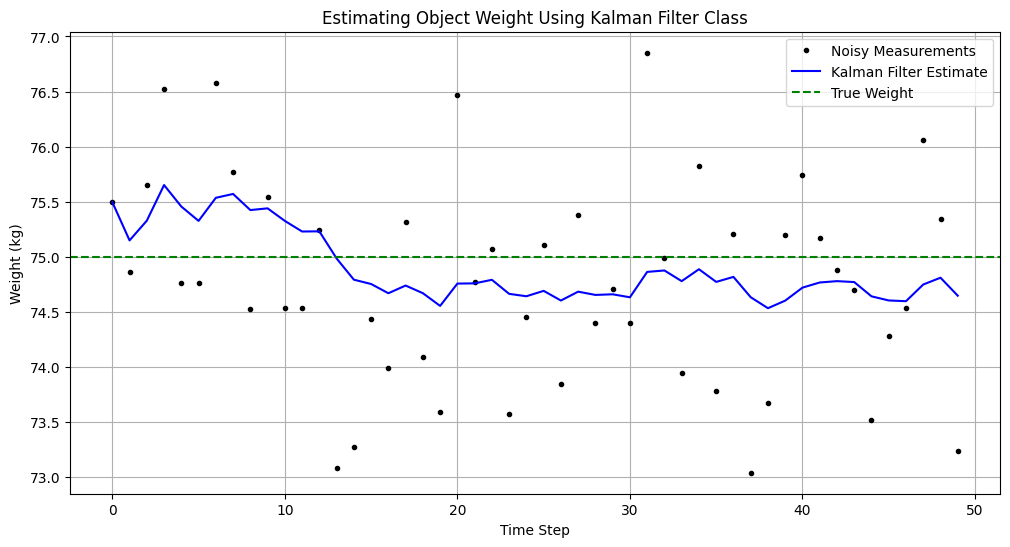

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(time_steps, measurements, 'k.', label='Noisy Measurements')
plt.plot(time_steps, x_estimates, 'b-', label='Kalman Filter Estimate')
plt.axhline(true_weight, color='g', linestyle='--', label='True Weight')
plt.xlabel('Time Step')
plt.ylabel('Weight (kg)')
plt.title('Estimating Object Weight Using Kalman Filter Class')
plt.legend()
plt.grid(True)
plt.show()


#Exercise 1: Implementing a Kalman Filter for Temperature Sensor Fusion
## Scenario:

You have two temperature sensors measuring the temperature of a room. Each sensor has its own measurement noise characteristics.

- **Sensor A** has a measurement noise variance of **1°C²**.
- **Sensor B** has a measurement noise variance of **2°C²**.

The true temperature varies slowly over time, and you can model it as a random walk process.

## Tasks:

1. **Model the System:**  
   - Define the state vector, state transition model $ F $, and observation model $ H $ for this system.

2. **Implement the Kalman Filter:**
   - Write a Python class for the Kalman Filter tailored to this temperature estimation problem. **<font color='red'>( refer to Example 1 )</font>**
   - Initialize the filter with appropriate matrices $ Q $ (process noise covariance), $ R $ (measurement noise covariance), and initial state estimate $ x_0 $.

3. **Sensor Fusion:**
   - Since we have two sensors, we'll update the Kalman Filter twice at each time step—once with each sensor's measurement. This approach allows us to fuse the information from both sensors to obtain a better estimate of the true temperature.

5. **Visualization:**
   - Plot the true temperature, the measurements from both sensors, and the Kalman Filter estimates over time.



The true temperature starts at 20 ∘C and changes slowly over time with a small process noise. Use the following code to generate the true temperature profile over 50 time steps。
 Use the following code to generate noisy measurements from Sensor A and Sensor B

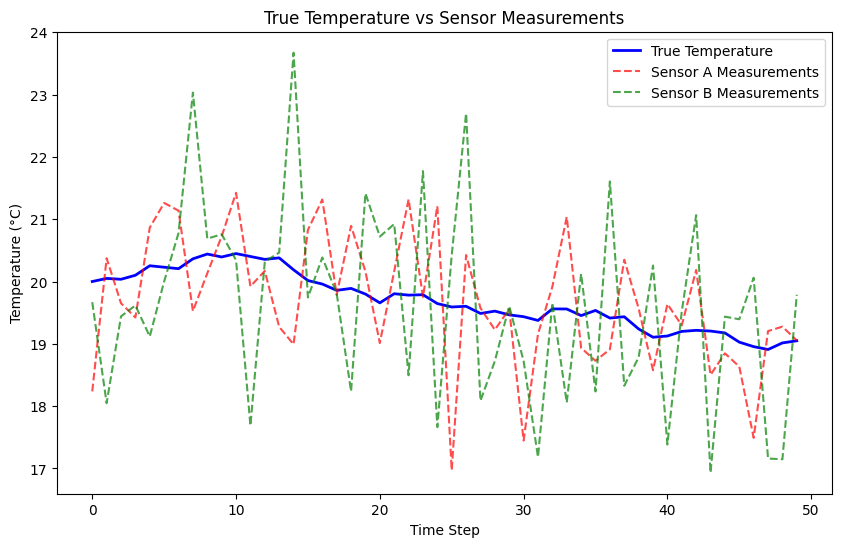

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)  # For reproducibility

num_steps = 50
true_temperature = [20.0]  # Starting at 20°C
process_noise_std = 0.1    # Small process noise

for _ in range(1, num_steps):
    temp = true_temperature[-1] + np.random.normal(0, process_noise_std)
    true_temperature.append(temp)


measurement_noise_std_A = np.sqrt(1)  # Sensor A noise
measurement_noise_std_B = np.sqrt(2)  # Sensor B noise

measurements_A = [temp + np.random.normal(0, measurement_noise_std_A) for temp in true_temperature]
measurements_B = [temp + np.random.normal(0, measurement_noise_std_B) for temp in true_temperature]
plt.figure(figsize=(10, 6))
plt.plot(true_temperature, label="True Temperature", color='blue', linewidth=2)
plt.plot(measurements_A, label="Sensor A Measurements", color='red', linestyle='dashed', alpha=0.7)
plt.plot(measurements_B, label="Sensor B Measurements", color='green', linestyle='dashed', alpha=0.7)

# Adding labels and title
plt.title("True Temperature vs Sensor Measurements")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")

# Adding a legend
plt.legend()

# Show the plot
plt.show()

 ##    **<font color='red'> Deliverables </font>**

- Complete Python code implementing the Kalman Filter and performing the estimation.
- A plot showing the true temperature, sensor measurements, and Kalman Filter estimates.

##    **<font color='blue'> Please complete your code in the space below </font>**

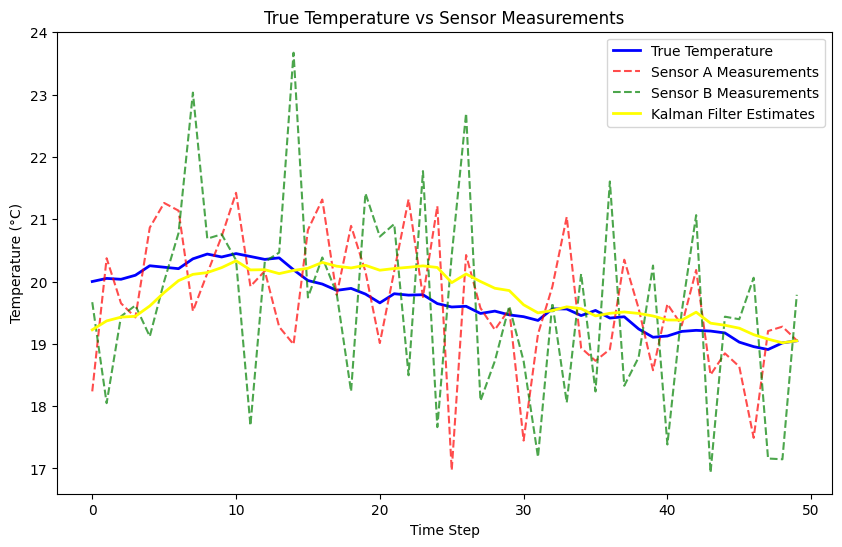

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, F, H, Q, R, x0, P0):
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance

        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimation error covariance

        # Lists to store estimates
        self.x_history = []
        self.P_history = []
        self.K_history = []

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)
        self.x = self.x + K @ (z - self.H @ self.x)
        self.P = (np.eye(len(K)) - K @ self.H) @ self.P

        # Store the Kalman Gain
        self.K_history.append(K)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
num_steps = 50
true_temperature = [20.0]
process_noise_std = 0.1

# Generate true temperature values
for _ in range(1, num_steps):
    temp = true_temperature[-1] + np.random.normal(0, process_noise_std)
    true_temperature.append(temp)

# Measurement noise characteristics
measurement_noise_std_A = np.sqrt(1)  # Sensor A noise
measurement_noise_std_B = np.sqrt(2)  # Sensor B noise

# Simulate sensor measurements
measurements_A = [temp + np.random.normal(0, measurement_noise_std_A) for temp in true_temperature]
measurements_B = [temp + np.random.normal(0, measurement_noise_std_B) for temp in true_temperature]

# Kalman Filter initialization
x0 = np.array([[true_temperature[0]]])
P0 = np.array([[1.0]])
F = np.array([[1]])
H = np.array([[1]])
Q_estimated = np.array([[process_noise_std**2]])
R_A = np.array([[measurement_noise_std_A**2]])
R_B = np.array([[measurement_noise_std_B**2]])

# Create an instance of the KalmanFilter class
kf = KalmanFilter(F=F, H=H, Q=Q_estimated, R=R_A, x0=x0, P0=P0)

# Run the Kalman Filter with the measurements from both sensors
for i in range(num_steps):
    kf.predict()
    
    # Update with Sensor A measurement
    kf.R = R_A
    kf.update(np.array([[measurements_A[i]]]))

    # Update with Sensor B measurement
    kf.R = R_B
    kf.update(np.array([[measurements_B[i]]]))

    # Store the estimate only once per time step
    kf.x_history.append(kf.x.copy())
    kf.P_history.append(kf.P.copy())

# Extract the estimates
x_estimates = np.array(kf.x_history).squeeze()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(true_temperature, label="True Temperature", color='blue', linewidth=2)
plt.plot(measurements_A, label="Sensor A Measurements", color='red', linestyle='dashed', alpha=0.7)
plt.plot(measurements_B, label="Sensor B Measurements", color='green', linestyle='dashed', alpha=0.7)
plt.plot(x_estimates, label="Kalman Filter Estimates", color='yellow', linewidth=2)

# Adding labels and title
plt.title("True Temperature vs Sensor Measurements")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")

# Adding a legend
plt.legend()

# Show the plot
plt.show()


# Exersice 2: 1D Position and Velocity Estimation Using Kalman Filter in Uniform Linear Motion

Let's consider a simple example where we have a moving object, and we want to estimate its position and velocity over time using noisy position measurements.


## Objective:

Implement a Kalman Filter to estimate the position and velocity of an object moving in one dimension with constant velocity using noisy position measurements. Analyze the input data to calculate the process noise covariance $Q$ and measurement noise covariance $R$, as would be done in a real-world scenario.

## This is the data we generated, generated with the following code
1. **Generate True Position and Velocity Data**:
   - Simulate the motion over \( N = 50 \) time steps with a time interval $ \Delta t = 1 $ second.
   - Use an initial position $ x_0 = 0 $ meters and a constant velocity $ v = 2 $ m/s.
   - At each time step, update the position using the kinematic equation:
     $
     x_k = x_{k-1} + v \cdot \Delta t
     $

2. **Add Process Noise**:
   - Introduce process noise to simulate small random fluctuations in velocity.
   - Assume the process noise for velocity has a standard deviation $ \sigma_{\text{process}} = 0.1 $ m/s.
   - At each time step, add zero-mean Gaussian noise to the velocity:
     $
     v_k = v + w_k
     $
     where $ w_k \sim \mathcal{N}(0, \sigma_{\text{process}}^2) $.
   - Update the position using the noisy velocity:
     $
     x_k = x_{k-1} + v_k \cdot \Delta t
     $

3. **Generate Noisy Measurements**:
   - Assume only the position is measured, and the measurements are corrupted by measurement noise.
   - The measurement noise has a standard deviation $ \sigma_{\text{measurement}} = 1 $ meter.
   - Generate noisy position measurements by adding zero-mean Gaussian noise to the true positions:
     $
     z_k = x_k + \nu_k
     $
     where $ \nu_k \sim \mathcal{N}(0, \sigma_{\text{measurement}}^2) $.


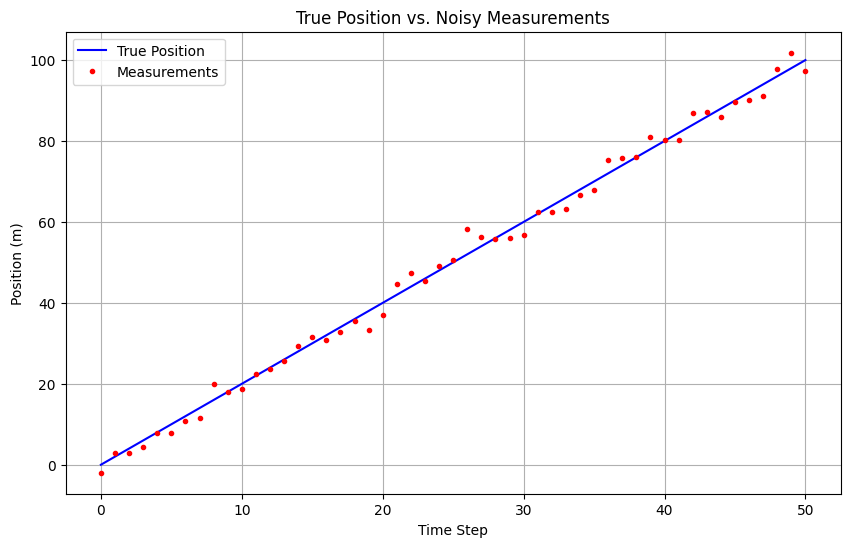

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time parameters
dt = 1.0  # Time step (seconds)
num_steps = 50  # Number of time steps

# Physical parameters
v_true = 2.0  # True constant velocity (m/s)
sigma_process = 0.1  # Standard deviation of process noise (m/s)
sigma_measurement = 2.0  # Standard deviation of measurement noise (m)

# Initial true state
x0 = 0.0  # Initial position (m)

# Initialize arrays to store true states
true_positions = [x0]
true_velocities = [v_true]  # True velocity remains constant

for k in range(1, num_steps + 1):
    # True velocity remains constant
    v_k = v_true
    # Update position
    x_k = true_positions[-1] + v_k * dt
    # Store true state
    true_positions.append(x_k)

# Measurement noise
measurement_noise = np.random.normal(0, sigma_measurement, size=num_steps + 1)
# Noisy position measurements
measurements = np.array(true_positions) + measurement_noise

# Time array for plotting
time_steps = np.arange(num_steps + 1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot true positions
plt.plot(time_steps, true_positions, label='True Position', color='blue', linestyle='-', )

# Plot noisy measurements
plt.plot(time_steps, measurements, 'r.', label='Measurements')

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.title('True Position vs. Noisy Measurements')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



   ## **<font color='red'> Deliverables </font>**

- The estimation of $Q$ and $R$ with calculations and explanations.

- The complete Kalman Filter implementation using your estimated covariance values.

- The plots of the results.（Compare the true position and estimated position
& Compare the true speed and estimated speed）

- Comments explaining each step of your code.

About the estimation of $Q$ and $R$:
- **Estimate Measurement Noise Covariance $ R $:**
  - Calculate the variance of the measurement errors.
  - Since the true positions are known (in this simulation), compute the differences between the measurements and true positions.
  - In real scenarios, you might use the residuals from the filter or known sensor characteristics.

- **Estimate Process Noise Covariance $ Q $:**
  - Calculate the variance of the process noise added to the velocity.
  - Alternatively, analyze the changes in velocity over time to estimate the covariance.


## **<font color='green'> Hints </font>**

- **Define the State Vector**:
  
$$
  \mathbf{x}_k =
  \begin{bmatrix}
  x_k \\
  v_k
  \end{bmatrix}
$$

- **State Transition Model $ F $**:
$$
  F =
  \begin{bmatrix}
  1 & \Delta t \\
  0 & 1
  \end{bmatrix}
$$

- **Process Noise Covariance $ Q $**:
  
  Since process noise is added to the velocity, and affects position through integration over time, $ Q $ can be defined as:
  
$$
  Q = \sigma_{\text{process}}^2 \cdot
  \begin{bmatrix}
  \Delta t^2 & \Delta t \\
  \Delta t & 1
  \end{bmatrix}
$$

- **Measurement Noise Covariance $ R $**:
$$
  R = \sigma_{\text{measurement}}^2
$$

- **Initial Estimates**:
  - Initial state estimate can be set to the first measurement and an initial guess for velocity.
  - Initial covariance $ P_0 $ can be set to a large value to reflect high initial uncertainty.

- **Matrix Operations**:
  - Use NumPy arrays for matrix calculations.
  - Ensure matrix dimensions are consistent.


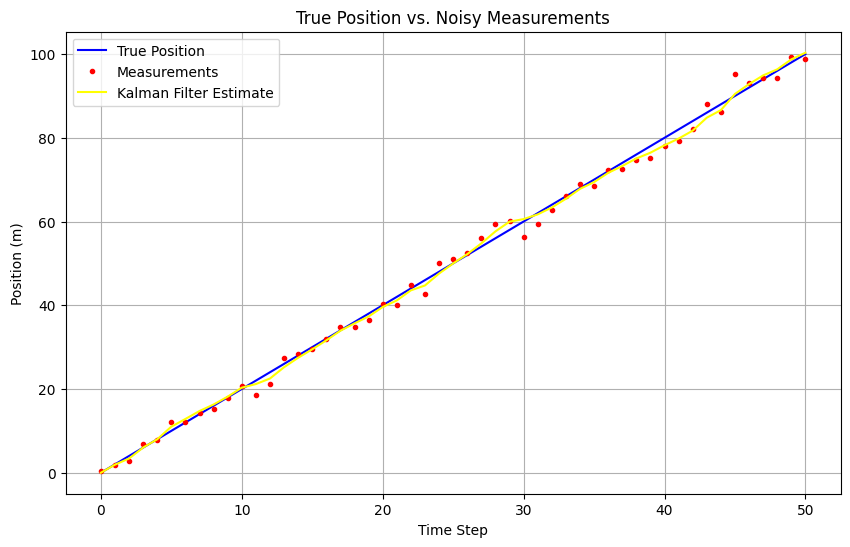

In [37]:
# Your code goes here......
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, F, H, Q, R, x0, P0):
        """
        Initialize the Kalman Filter.

        Parameters:
        - F: State transition matrix
        - H: Observation matrix
        - Q: Process noise covariance
        - R: Measurement noise covariance
        - x0: Initial state estimate
        - P0: Initial estimation error covariance
        """
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance

        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimation error covariance

        # Lists to store estimates
        self.x_history = [x0]
        self.P_history = [P0]
        self.K_history = []

    def predict(self):
        """Prediction step of the Kalman Filter."""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        """Update step of the Kalman Filter.

        Parameters:
        - z: The new measurement
        """
        S = self.H @ self.P @ self.H.T + self.R  # Residual covariance
        K = self.P @ self.H.T @ np.linalg.inv(S)  # Kalman gain
        
        # Update state and covariance
        self.x = self.x + K @ (z - (self.H @ self.x))
        self.P = (np.eye(2) - K @ self.H) @ self.P

        # Store the Kalman Gain and estimates
        self.K_history.append(K)
        self.x_history.append(self.x)
        self.P_history.append(self.P)

# Time parameters
dt = 1.0  # Time step (seconds)
num_steps = 50  # Number of time steps

# Physical parameters
v_true = 2.0  # True constant velocity (m/s)
sigma_process = 0.1  # Standard deviation of process noise (m/s)
sigma_measurement = 2.0  # Standard deviation of measurement noise (m)

# Initial true state
x0 = 0.0  # Initial position (m)

# Initialize arrays to store true states
true_positions = [x0]
true_velocities = [v_true]  # True velocity remains constant

for k in range(1, num_steps + 1):
    # True velocity remains constant
    v_k = v_true
    # Update position
    x_k = true_positions[-1] + v_k * dt
    # Store true state
    true_positions.append(x_k)

# Measurement noise
measurement_noise = np.random.normal(0, sigma_measurement, size=num_steps + 1)
# Noisy position measurements
measurements = np.array(true_positions) + measurement_noise

####kalman filter
# Estimate Measurement Noise Covariance
# Calculate the variance of the measurement errors
measurement_errors = measurements - np.array(true_positions)
R = np.var(measurement_errors)
# Estimate Process Noise Covariance Q
Q = sigma_process ** 2 * np.array([[dt**2, dt],
                                    [dt, 1]])
F = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])            # Observation matrix
# Initial state: position and velocity
x0 = np.array([[0], [v_true]])  # Initial position and velocity
P0 = np.eye(2)  # Initial covariance matrix
# Create an instance of KalmanFilter
kf = KalmanFilter(F, H, Q, R, x0, P0)
# loop for filtering
for z in measurements[1:]:  # Iterate through noisy measurements
    kf.predict()
    kf.update(np.array([[z]]))  # Update with the noisy measurement


# Time array for plotting
time_steps = np.arange(num_steps + 1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot true positions
plt.plot(time_steps, true_positions, label='True Position', color='blue', linestyle='-', )

# Plot noisy measurements
plt.plot(time_steps, measurements, 'r.', label='Measurements')

#plot kalman filter estimates
x_estimates = np.array(kf.x_history).squeeze()
plt.plot(time_steps, x_estimates[:, 0], label='Kalman Filter Estimate', color='yellow')

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.title('True Position vs. Noisy Measurements')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Limitations of the Standard Kalman Filter and Introduction to the Extended Kalman Filter (EKF)

In this section, we'll explore the limitations of the standard Kalman Filter when applied to non-linear systems and introduce the Extended Kalman Filter (EKF), which extends the Kalman Filter to handle non-linear models.

## Limitations of the Standard Kalman Filter

The standard Kalman Filter assumes that both the process model and the observation model are linear, which is not always the case in real-world applications. When dealing with non-linear systems, the linear Kalman Filter can produce suboptimal estimates or even diverge.

# Exersice 3: Kalman Filter Application on a 2D Nonlinear Motion Trajectory

## Objective
- To understand the application of the Kalman filter in estimating the position of an object moving along a nonlinear trajectory in 2D space.
- To implement a Kalman filter and analyze its performance in the context of nonlinear motion.



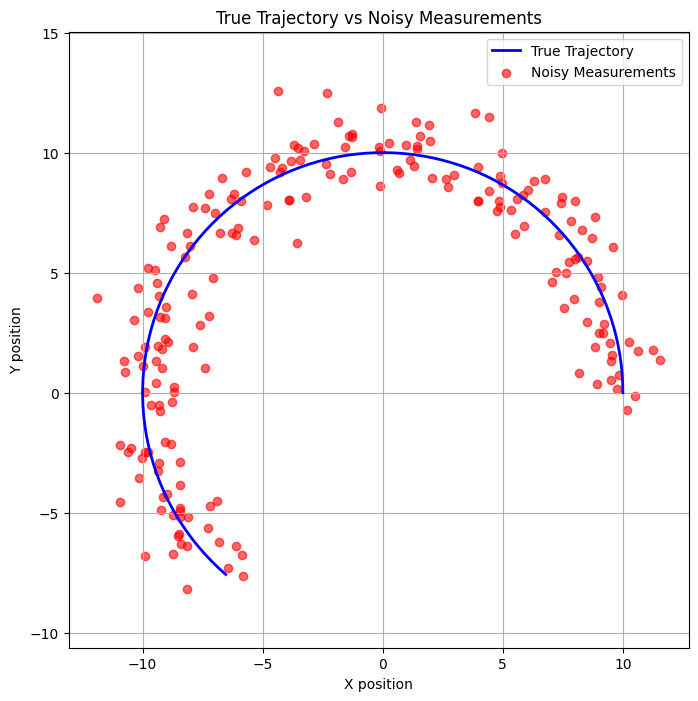

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 0.1  # Time step
t_total = 20  # Total time
t = np.arange(0, t_total + dt, dt)

# True trajectory (circular motion)
radius = 10
omega = 0.2  # Angular velocity
true_positions = np.zeros((len(t), 2))
for i, time in enumerate(t):
    true_positions[i, 0] = radius * np.cos(omega * time)
    true_positions[i, 1] = radius * np.sin(omega * time)

# Add measurement noise
np.random.seed(42)  # For reproducibility
measurement_noise_std = 1.0
measurements = true_positions + np.random.normal(0, measurement_noise_std, size=true_positions.shape)

# Visualization
plt.figure(figsize=(8, 8))
plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', color='blue', linewidth=2)
plt.scatter(measurements[:, 0], measurements[:, 1], label='Noisy Measurements', color='red', alpha=0.6)
plt.title('True Trajectory vs Noisy Measurements')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling of the axes
plt.show()

## **<font color='red'> Deliverables </font>**


- Complete Python code implementing the Kalman Filter and performing the estimation

- The plots of the results.（Compare the true position and estimated position
& Compare the true speed and estimated speed）

- Comments explaining each step of your code.

## **<font color='green'> Hints </font>**

To assist you in completing the assignment, here are some hints on key components:

### 1. Defining the State Vector

The **state vector** represents the set of variables that describe the system's current state. For tracking position and velocity in 2D space, you can define the state vector as:

$$
\mathbf{x} =
\begin{bmatrix}
x \\
y \\
v_x \\
v_y
\end{bmatrix}
$$

- $ x, y $: Position coordinates.
- $ v_x, v_y $: Velocity components in the x and y directions.

### 2. State Transition Model

The **state transition model** describes how the state evolves from one time step to the next. Assuming a **constant velocity model**, the state transition can be defined using the following equation:

$$
\mathbf{x}_k = \mathbf{F} \mathbf{x}_{k-1} + \mathbf{w}_{k-1}
$$

Where:
- **$ \mathbf{F} $** is the state transition matrix.
- **$ \mathbf{w}_{k-1} $** is the process noise, accounting for uncertainties in the model.

For a constant velocity model with time step $ dt $, the state transition matrix $ \mathbf{F} $ is:

$$
\mathbf{F} =
\begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### 3. Process Noise Covariance

The **process noise covariance matrix** $ \mathbf{Q} $ represents the uncertainty in the state transition model. It accounts for random accelerations and other unmodeled dynamics. For a constant velocity model, $ \mathbf{Q} $ can be defined as:
In here, we assume the **<font color='red'> $q$ = 0.1 </font>**.
$$
\mathbf{Q} = q \cdot
\begin{bmatrix}
\frac{dt^4}{4} & 0 & \frac{dt^3}{2} & 0 \\
0 & \frac{dt^4}{4} & 0 & \frac{dt^3}{2} \\
\frac{dt^3}{2} & 0 & dt^2 & 0 \\
0 & \frac{dt^3}{2} & 0 & dt^2
\end{bmatrix}
$$

- $ q $ is a scalar representing the magnitude of the process noise.
- The terms involve $ dt $ to scale the process noise according to the time step.

### 4. Measurement Model

The **measurement model** relates the true state to the observed measurements. It is defined as:

$$
z_k = \mathbf{H} \mathbf{x}_k + v_k
$$

Where:
- $ z_k $ is the measurement vector.
- $ \mathbf{H} $ is the observation matrix.
- $ v_k $ is the measurement noise.

For position measurements only, the observation matrix $ \mathbf{H} $ is:

$$
\mathbf{H} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

### 5. Measurement Noise Covariance

The **measurement noise covariance matrix** $ \mathbf{R} $ represents the uncertainty in the measurements. If the measurement noise in both x and y directions is independent and has the same variance $ r $, then:

$$
\mathbf{R} = r \cdot
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

- $r $ is the variance of the measurement noise (e.g., $ \sigma_{\text{measurement}}^2 $). In here we assume the **<font color='red'> $r$ = 1 </font>**.



##    **<font color='blue'> Please complete your code in the space below </font>**

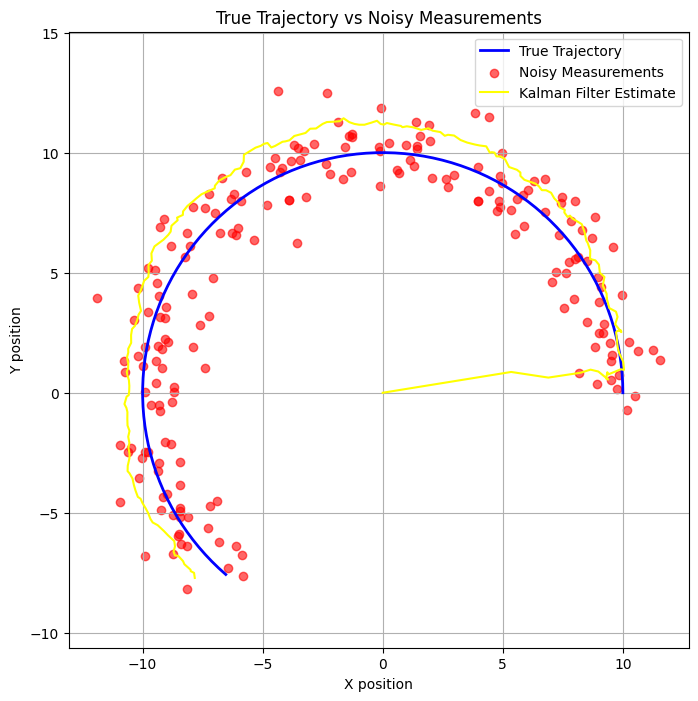

In [44]:
# Your code go here ......
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, F, H, Q, R, x0, P0):
        """
        Initialize the Kalman Filter.

        Parameters:
        - F: State transition matrix
        - H: Observation matrix
        - Q: Process noise covariance
        - R: Measurement noise covariance
        - x0: Initial state estimate
        - P0: Initial estimation error covariance
        """
        self.F = F  # State transition matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance

        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimation error covariance

        # Lists to store estimates
        self.x_history = [x0]
        self.P_history = [P0]
        self.K_history = []

    def predict(self):
        """Prediction step of the Kalman Filter."""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        """Update step of the Kalman Filter.

        Parameters:
        - z: The new measurement
        """
        S = self.H @ self.P @ self.H.T + self.R  # Residual covariance
        K = self.P @ self.H.T @ np.linalg.inv(S)  # Kalman gain
        
        # Update state and covariance
        self.x = self.x + K @ (z - (self.H @ self.x))
        self.P = (np.eye(4) - K @ self.H) @ self.P

        # Store the Kalman Gain and estimates
        self.K_history.append(K)
        self.x_history.append(self.x)
        self.P_history.append(self.P)

# Simulation parameters
dt = 0.1  # Time step
t_total = 20  # Total time
t = np.arange(0, t_total + dt, dt)

# True trajectory (circular motion)
radius = 10
omega = 0.2  # Angular velocity
true_positions = np.zeros((len(t), 2))
for i, time in enumerate(t):
    true_positions[i, 0] = radius * np.cos(omega * time)
    true_positions[i, 1] = radius * np.sin(omega * time)

# Add measurement noise
np.random.seed(42)  # For reproducibility
measurement_noise_std = 1.0
measurements = true_positions + np.random.normal(0, measurement_noise_std, size=true_positions.shape)

##kalman filter
# Estimate Measurement Noise Covariance
R = 1 * np.eye(2)
# Estimate Process Noise Covariance Q
Q = 0.1 * np.array([[dt**4 / 4, 0, dt**3 / 2, 0],
                  [0, dt**4 / 4, 0, dt**3 / 2],
                  [dt**3 / 2, 0, dt**2, 0],
                  [0, dt**3 / 2, 0, dt**2]])
# State transition matrix
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
# Observation matrix
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
# Initial state: position (0, 0) and velocity (2, 2)
x0 = np.array([[0], [0], [0], [0]])  
P0 = np.eye(4)  # Initial covariance
# Create an instance of KalmanFilter
kf = KalmanFilter(F, H, Q, R, x0, P0)
# loop for filtering
for z in measurements[1:]:  # Iterate through noisy measurements
    kf.predict()
    kf.update(z.reshape(-1, 1))

# Visualization
plt.figure(figsize=(8, 8))
plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', color='blue', linewidth=2)
plt.scatter(measurements[:, 0], measurements[:, 1], label='Noisy Measurements', color='red', alpha=0.6)
#kalman filter estimates
x_estimates = np.array(kf.x_history)
plt.plot(x_estimates[:, 0], x_estimates[:, 1], label='Kalman Filter Estimate', color='yellow')
plt.title('True Trajectory vs Noisy Measurements')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling of the axes
plt.show()



# Introduction to the Extended Kalman Filter (EKF)

To handle non-linear systems, we can use the Extended Kalman Filter (EKF), which linearizes the non-linear models around the current estimate.

## EKF Overview

The EKF approximates a non-linear system by linearizing the non-linear functions using Taylor series expansion (first-order approximation).

**Non-linear State Transition and Observation Models:**

- **Process Model:**
$$
x_k = f(x_{k-1}, u_{k-1}) + w_k
$$
- **Observation Model:**
$$
z_k = h(x_k) + v_k
$$

Where:

- $ f $ and $ h $ are non-linear functions.
- $ w_k $ and $ v_k $ are process and measurement noise.

**Linearization using Jacobians:**

- **State Transition Jacobian \( F_k \):**
$$
F_k = \left. \frac{\partial f}{\partial x} \right|_{x = \hat{x}_{k-1}}
$$
- **Observation Jacobian \( H_k \):**
$$
H_k = \left. \frac{\partial h}{\partial x} \right|_{x = \hat{x}_{k|k-1}}
$$

## EKF Algorithm Steps

1. **Prediction:**
   - Predict the state:
$$
\hat{x}_{k|k-1} = f(\hat{x}_{k-1|k-1}, u_{k-1})
$$
   - Predict the error covariance:
$$
P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_k
$$

2. **Update:**
   - Compute the Kalman Gain:
$$
K_k = P_{k|k-1} H_k^T \left( H_k P_{k|k-1} H_k^T + R_k \right)^{-1}
$$
   - Update the state estimate:
$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k \left( z_k - h(\hat{x}_{k|k-1}) \right)
$$
   - Update the error covariance:
$$
P_{k|k} = \left( I - K_k H_k \right) P_{k|k-1}
$$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, state_dim, meas_dim, dt, process_noise_cov, measurement_noise_cov):
        """
        Initialize the Extended Kalman Filter.

        Parameters:
        - state_dim: Dimension of the state vector.
        - meas_dim: Dimension of the measurement vector.
        - dt: Time step.
        - process_noise_cov: Process noise covariance matrix (Q).
        - measurement_noise_cov: Measurement noise covariance matrix (R).
        """
        self.state_dim = state_dim
        self.meas_dim = meas_dim
        self.dt = dt
        self.Q = process_noise_cov
        self.R = measurement_noise_cov

        # Initialize state estimate and covariance
        self.x = np.zeros(state_dim)
        self.P = np.eye(state_dim)

    def f(self, x):
        """
        Non-linear state transition function.
        """
        # State transition model: constant velocity model
        x_new = np.zeros_like(x)
        x_new[0] = x[0] + x[2] * self.dt  # x position update
        x_new[1] = x[1] + x[3] * self.dt  # y position update
        x_new[2] = x[2]  # v_x remains the same
        x_new[3] = x[3]  # v_y remains the same
        return x_new

    def F_jacobian(self):
        """
        Jacobian of the state transition function.
        """
        return np.array([
            [1, 0, self.dt, 0],
            [0, 1, 0, self.dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def h(self, x):
        """
        Measurement function.
        """
        return np.array([x[0], x[1]])

    def H_jacobian(self):
        """
        Jacobian of the measurement function.
        """
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

    def predict(self):
        """
        Prediction step of the EKF.
        """
        # Predict the state estimate
        self.x = self.f(self.x)
        # Compute the Jacobian of the state transition function
        F_k = self.F_jacobian()
        # Predict the error covariance
        self.P = F_k @ self.P @ F_k.T + self.Q
        # The @ operator can be used as a shorthand for np.matmul on ndarrays. np.matmul return the Matrix product of two arrays.

    def update(self, z):
        """
        Update step of the EKF.

        Parameters:
        - z: Measurement vector.
        """
        # Compute the Jacobian of the measurement function
        H_k = self.H_jacobian()
        # Measurement residual
        y = z - self.h(self.x)
        # Residual covariance
        S = H_k @ self.P @ H_k.T + self.R
        # Kalman gain
        K = self.P @ H_k.T @ np.linalg.inv(S)
        # Update the state estimate
        self.x = self.x + K @ y
        # Update the error covariance
        self.P = (np.eye(self.state_dim) - K @ H_k) @ self.P

    # The @ operator can be used as a shorthand for np.matmul on ndarrays. np.matmul return the Matrix product of two arrays.

In [ ]:
# Simulation parameters
dt = 0.1  # Time step (s)
t_total = 20  # Total time (s)
t = np.arange(0, t_total + dt, dt)  # Time vector


# True trajectory parameters
radius = 10  # Radius of the circle (units)
omega = 0.2  # Angular velocity (rad/s)

# True positions
true_positions = np.zeros((len(t), 2))
for i, time in enumerate(t):
    true_positions[i, 0] = radius * np.cos(omega * time)  # x-coordinate
    true_positions[i, 1] = radius * np.sin(omega * time)  # y-coordinate


# Measurement noise
np.random.seed(42)  # For reproducibility
measurement_noise_std = 1.0  # Standard deviation of measurement noise

# Noisy measurements
measurements = true_positions + np.random.normal(
    0, measurement_noise_std, size=true_positions.shape
)


### State Vector and Covariance

The state vector includes position and velocity components:
$$
\mathbf{x} = \begin{bmatrix}
x \\
y \\
v_x \\
v_y
\end{bmatrix}
$$

- **Initial State Estimate $ \mathbf{x} $**: Initialized with the first measurement and zero velocity.
- **Initial Error Covariance $ \mathbf{P}$**: Represents uncertainty in the initial estimate.


###  Process and Measurement Noise Covariances

- **Process Noise Covariance $\mathbf{Q} $**: Represents uncertainty in the process model.
- **Measurement Noise Covariance $ \mathbf{R} $**: Based on the measurement noise standard deviation.

###  Non-linear State Transition Function $ f$ and Jacobian $ \mathbf{F}_k $

In this example, we use a linear motion model with constant velocity. However, for demonstration, we'll treat it as a non-linear function.

#### State Transition Function:

$$
\mathbf{x}_k = f(\mathbf{x}_{k-1}) =
\begin{bmatrix}
x_{k-1} + v_{x,k-1} \Delta t \\
y_{k-1} + v_{y,k-1} \Delta t \\
v_{x,k-1} \\
v_{y,k-1}
\end{bmatrix}
$$

#### State Transition Jacobian:

$$
\mathbf{F}_k = \frac{\partial f}{\partial \mathbf{x}} =
\begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

###  Non-linear Measurement Function $ h $ and Jacobian $ \mathbf{H}_k $

The measurement function relates the state to the measurements.

#### Measurement Function:

$$
\mathbf{z}_k = h(\mathbf{x}_k) =
\begin{bmatrix}
x_k \\
y_k
\end{bmatrix}
$$
#### Measurement Function Jacobian:

$$
\mathbf{H}_k = \frac{\partial h}{\partial \mathbf{x}} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$



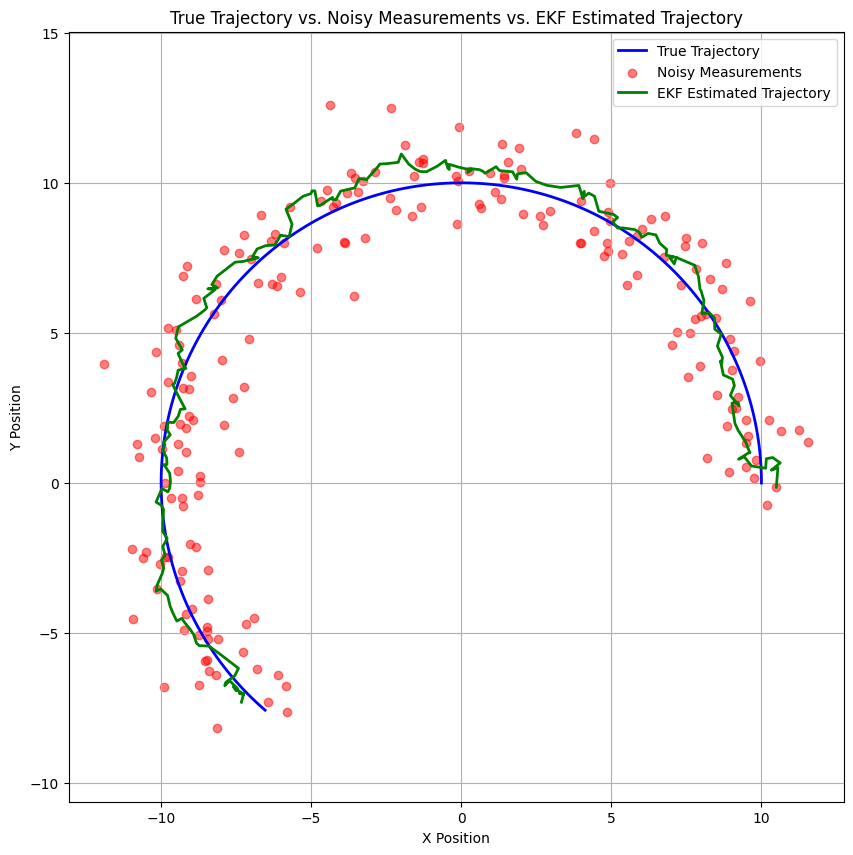

In [ ]:
# State and measurement dimensions
state_dim = 4  # [x, y, v_x, v_y]
meas_dim = 2   # [x, y]

# Process and measurement noise covariance matrices
Q = np.eye(state_dim) * 0.01  # Process noise covariance
R = np.eye(meas_dim) * measurement_noise_std**2  # Measurement noise covariance

# Initialize the EKF
ekf = ExtendedKalmanFilter(state_dim, meas_dim, dt, Q, R)

# Set initial state estimate and covariance
ekf.x = np.array([measurements[0, 0], measurements[0, 1], 0.0, 0.0])
ekf.P = np.eye(state_dim)


# Number of time steps
n_steps = len(t)

# Array to store estimated states
estimated_states = np.zeros((n_steps, state_dim))

for k in range(n_steps):
    # Prediction step
    ekf.predict()

    # Update step with the current measurement
    z = measurements[k]
    ekf.update(z)

    # Store the estimated state
    estimated_states[k] = ekf.x



# Plotting
plt.figure(figsize=(10, 10))

# True trajectory
plt.plot(
    true_positions[:, 0], true_positions[:, 1],
    label='True Trajectory', color='blue', linewidth=2
)

# Noisy measurements
plt.scatter(
    measurements[:, 0], measurements[:, 1],
    label='Noisy Measurements', color='red', alpha=0.5
)

# EKF estimated trajectory
plt.plot(
    estimated_states[:, 0], estimated_states[:, 1],
    label='EKF Estimated Trajectory', color='green', linewidth=2
)

plt.title('True Trajectory vs. Noisy Measurements vs. EKF Estimated Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


## Conclusion
The Extended Kalman Filter effectively estimates the object's position and velocity, despite the presence of measurement noise. The EKF estimates closely follow the true trajectory, demonstrating the filter's capability to handle non-linear motion models.

#Exercise 4: Implementing an Extended Kalman Filter (EKF) for Robot Localization

## Objective:

In this assignment, you will implement an Extended Kalman Filter (EKF) to fuse wheel odometry and IMU measurements for estimating the pose (position and orientation) of a mobile robot. This exercise will deepen your understanding of the EKF and its application in robotic state estimation.

## Background:

Robots often rely on various sensors to estimate their position and orientation in an environment. Wheel odometry provides relative motion estimates by measuring the rotation of the wheels, but it is susceptible to errors due to wheel slippage or uneven terrain. Inertial Measurement Units (IMUs) provide orientation measurements, but they can drift over time. By fusing data from both sensors using an EKF, we can obtain a more accurate and robust estimate of the robot's pose.

## Dataset:

You are provided with a CSV file named ros_data.csv that contains time-stamped data from wheel odometry and IMU sensors, as well as ground truth measurements for validation.

### Use following cmd to download the dataset

In [ ]:
!wget https://raw.github.com/Hasar12138/course_data/main/ros_data.csv

--2024-10-07 10:18:08--  https://raw.github.com/Hasar12138/course_data/main/ros_data.csv
Resolving raw.github.com (raw.github.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/Hasar12138/course_data/main/ros_data.csv [following]
--2024-10-07 10:18:08--  https://raw.githubusercontent.com/Hasar12138/course_data/main/ros_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214591 (210K) [text/plain]
Saving to: ‘ros_data.csv’

ros_data.csv        100%[===================>] 209.56K  --.-KB/s    in 0.05s   

2024-10-07 10:18:08 (4.18 MB/s) - ‘ros_data.csv’ saved [

In [ ]:
import pandas as pd

data = pd.read_csv('ros_data.csv')
print(data.head())

           time  husky_odom_pose_x  husky_odom_pose_y  husky_odom_pose_theta  \
0  1.728293e+09           0.000509      -4.547798e-10          -3.539790e-07   
1  1.728293e+09           0.000510      -4.549861e-10          -3.539228e-07   
2  1.728293e+09           0.000510      -4.551923e-10          -3.538666e-07   
3  1.728293e+09           0.000510      -4.553986e-10          -3.538104e-07   
4  1.728293e+09           0.000510      -4.556048e-10          -3.537543e-07   

   imu_orientation_x  imu_orientation_y  imu_orientation_z  imu_orientation_w  \
0           0.000294           0.000104       7.872934e-07                1.0   
1           0.000294           0.000103       7.874015e-07                1.0   
2           0.000294           0.000103       7.875092e-07                1.0   
3           0.000294           0.000104       7.876147e-07                1.0   
4           0.000294           0.000103       7.877220e-07                1.0   

   filtered_odom_pose_x  filtere

### **Introduction to dataset**

#### **1**.Wheel odometry Data (husky_odom_pose_x,husky_odom_pose_y,husky_odom_pose_thata)
Odometry refers to the use of data from motion sensors (typically wheel encoders) to estimate the change in position and orientation of a robot over time. For a ground robot like the Husky, odometry data typically consists of:

- Position Data: This is usually represented by (x, y) coordinates, which track the robot's movement in a 2D space.
- Orientation (Theta): This is the angular position of the robot, often referred to as "theta" (θ), which indicates the robot's direction or heading in the plane.

Wheel odometry data is essential for localization and navigation tasks in mobile robots but can accumulate errors over time, especially due to wheel slippage or uneven terrain. So we need to imrove it by fusing data from other sensors like IMU.

#### **2**.IMU (Inertial Measurement Unit) Data (imu_orientation_x ,imu_orientation_y,imu_orientation_z,imu_orientation_w)
An IMU is a sensor that provides data on the robot's orientation, acceleration, and angular velocity. It typically consists of:

- Accelerometers: Measure linear acceleration in three axes (x, y, z).
- Gyroscopes: Measure angular velocity around three axes (roll, pitch, yaw).

In Here, the IMU data is represented by:

**imu_orientation_x, imu_orientation_y, imu_orientation_z, imu_orientation_w**: These values represent the orientation of the robot in 3D space using quaternions (a mathematical representation that avoids issues like gimbal lock, common in simpler Euler angle representations).

#### **3**.Ground Truth (filtered_odom_pose_x,filtered_odom_pose_y,filtered_odom_pose_thata)
This is the true value of the odomtery data, the original appearance of the robot trajectory

#### **4**.visualization the input data and Ground Truth
Below is what looks like the input wheel odometry, IMU and ground truth odometry .



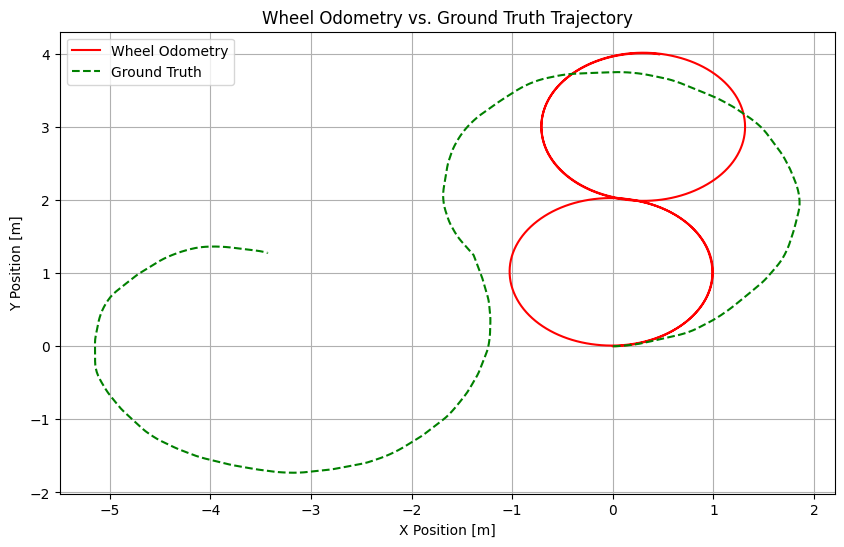

In [ ]:
time = data['time'].values
x_odom = data['husky_odom_pose_x'].values
y_odom = data['husky_odom_pose_y'].values
theta_odom = data['husky_odom_pose_theta'].values
imu_orientation_x = data['imu_orientation_x'].values
imu_orientation_y = data['imu_orientation_y'].values
imu_orientation_z = data['imu_orientation_z'].values
imu_orientation_w = data['imu_orientation_w'].values
x_gt = data['filtered_odom_pose_x'].values
y_gt = data['filtered_odom_pose_y'].values
theta_gt = data['filtered_odom_pose_theta'].values

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_odom, y_odom, 'r-', label='Wheel Odometry')
plt.plot(x_gt, y_gt, 'g--', label='Ground Truth')
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.title('Wheel Odometry vs. Ground Truth odometry')
plt.legend()
plt.grid(True)
plt.show()


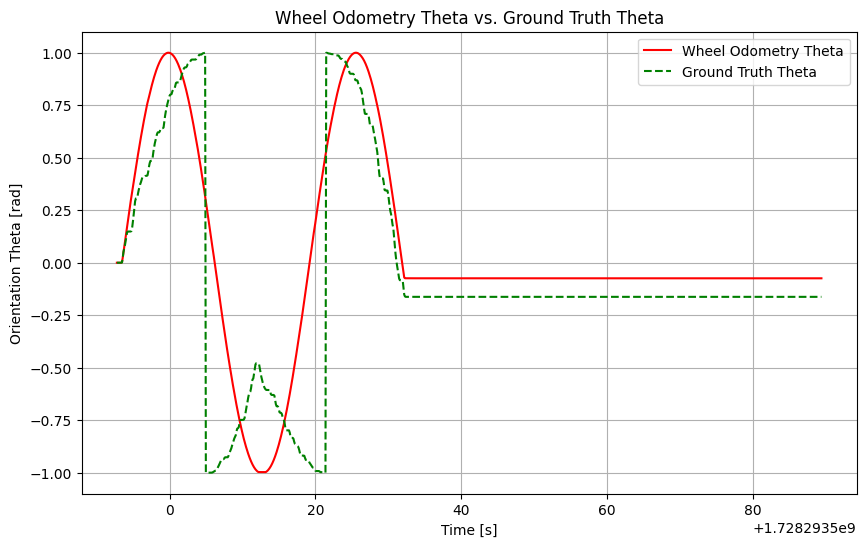

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time, theta_odom, 'r-', label='Wheel Odometry Theta')
plt.plot(time, theta_gt, 'g--', label='Ground Truth Theta')
plt.xlabel('Time [s]')
plt.ylabel('Orientation Theta [rad]')
plt.title('Wheel Odometry Theta vs. Ground Truth Theta')
plt.legend()
plt.grid(True)
plt.show()


## **<font color='red'> Deliverables </font>**
- Implement the EKF as a Class
- Apply the EKF class to the data to get the fused odometry
- Visualization (Compare the true position and estimated position)

##    **<font color='green'>Hints </font>**

### 1.State Vector (x):

The state vector at each time step $ k $ is:
$$
\mathbf{x}_k = \begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix}
$$

### 2.Motion Model (Prediction Step):

The robot's motion can be approximated by:
$$
\begin{aligned}
x_k &= x_{k-1} + \delta s \cos(\theta_{k-1}) \\
y_k &= y_{k-1} + \delta s \sin(\theta_{k-1}) \\
\theta_k &= \theta_{k-1} + \delta \theta
\end{aligned}
$$
where:
$$
\begin{aligned}
\delta s &= \sqrt{(\delta x)^2 + (\delta y)^2} \\
\delta x &= x_{\text{odom}, k} - x_{\text{odom}, k-1} \\
\delta y &= y_{\text{odom}, k} - y_{\text{odom}, k-1} \\
\delta \theta &= \theta_{\text{odom}, k} - \theta_{\text{odom}, k-1}
\end{aligned}
$$

### 3.Jacobian of the Motion Model $ \mathbf{F}_k $:

$$
\mathbf{F}_k = \begin{bmatrix}
1 & 0 & -\delta s \sin(\theta_{k-1}) \\
0 & 1 & \delta s \cos(\theta_{k-1}) \\
0 & 0 & 1
\end{bmatrix}
$$

### 4. Measurement Model (Update Step):


#### 4.1 Processing and Fusing IMU Data
- The measurement model relates the state to the observed measurements:
$$
  z_k = h(\mathbf{x}_k) + v_k
$$
  where:
  - $ h(\mathbf{x}_k) = \theta_k $: the measurement function, which in this case is the orientation component of the state.
  - $ v_k $: measurement noise, assumed to be Gaussian with covariance $\mathbf{R} $.

#### 4.2 IMU Data Processing:
- The IMU provides orientation in the form of quaternions ($q_x, q_y, q_z, q_w$).
- **Convert the quaternion to a yaw angle $ \theta $** using mathematical transformations.
- The yaw angle represents the robot's orientation around the vertical axis.

#### 4.3 Conversion from Quaternion to Yaw Angle

Given a quaternion $ q = (q_x, q_y, q_z, q_w) $, the yaw angle $ \theta$ can be obtained using:
$$
\theta = \arctan 2(2(q_w q_z + q_x q_y), 1 - 2(q_y^2 + q_z^2))
$$

Alternatively, use a library function (e.g., from `scipy.spatial.transform`) to perform this conversion.











### 5.Jacobian of the Measurement Model $ \mathbf{H}_k $:

$$
\mathbf{H}_k = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}
$$

### 6.How to Determine Q:

- **Modeling Uncertainty Sources**:
  - **Translational Motion Noise (σₛ)**: Uncertainty in distance traveled.
  - **Rotational Motion Noise (σθ)**: Uncertainty in the rotation angle.

- **Constructing Q**:
$$
\mathbf{Q} = \begin{bmatrix}
\sigma_x^2 & 0 & 0 \\
0 & \sigma_y^2 & 0 \\
0 & 0 & \sigma_\theta^2
\end{bmatrix}
$$

- **Estimating Noise Values**:
  - Start with reasonable estimates based on sensor specifications or empirical data.
  - For example:

```python
sigma_s = 0.1  # Standard deviation of translational noise [m]
sigma_theta = 0.05  # Standard deviation of rotational noise [rad]
Q = np.diag([sigma_s**2, sigma_s**2, sigma_theta**2])


### How to Determine R:

- **Based on Sensor Specifications**:
  - Check the datasheet of the IMU for the noise characteristics (e.g., standard deviation of the orientation measurement).

- **Empirical Estimation**:
  - Collect a series of measurements with the robot stationary to estimate the variance.

- **Constructing R**:
$$
\mathbf{R} = \begin{bmatrix} \sigma_{\text{imu}}^2 \end{bmatrix}
$$

- **Example**:

```python
sigma_imu = 0.01  # Standard deviation of IMU orientation noise [rad]
R = np.array([[sigma_imu**2]])


##    **<font color='blue'> Please complete your code in the space below </font>**

[0. 0. 0.]


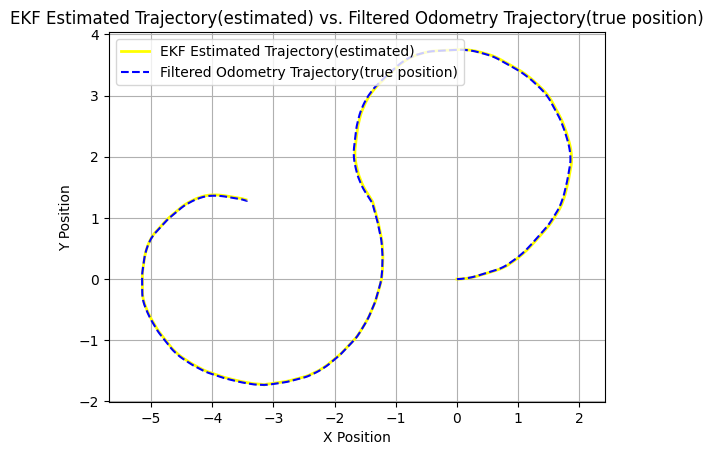

In [78]:
# Your code goes here ......
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, Q, R, x0, P0):
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimation error covariance

    def f(self, state, odom_k, odom_k_minus_1):
        """State transition function."""
        # Calculate the new state based on odometry
        delta_x = odom_k[0] - odom_k_minus_1[0]
        delta_y = odom_k[1] - odom_k_minus_1[1]
        delta_theta = odom_k[2] - odom_k_minus_1[2]

        delta_s = np.sqrt(delta_x**2 + delta_y**2) #see detials in hint

        new_x = state[0] + delta_s * np.cos(state[2])
        new_y = state[1] + delta_s * np.sin(state[2])
        new_theta = state[2] + delta_theta

        return np.array([new_x, new_y, new_theta])

    def h(self, state):
        return np.array([[state[2]]])  # Predicted measurement

    def predict(self, odom_k, odom_k_minus_1):
        """Prediction step."""
        # Predict state
        self.x = self.f(self.x, odom_k, odom_k_minus_1)
        # Compute Jacobian for the state transition
        F = self.jacobian_f(self.x, odom_k, odom_k_minus_1)
        # Predict covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, imu_measurement):
        """Update step."""
        # Convert the IMU measurement to a yaw angle
        yaw_angle = self.convert_quaternion_to_yaw(imu_measurement)  # imu_measurement [x, y, z, w]
        # measurement vector
        z = np.array([[yaw_angle]])  # Actual measurement (yaw angle)
        z_pred = self.h(self.x)  # Predicted measurement from the state
        
        # Compute Jacobian for the measurement function
        H = self.jacobian_h(self.x)
        y = z - z_pred  # Residual
        # Ensure y is 1D, since both our x0 and H are in shape of (1,1), we should flatern y
        #otherwise self.x = self.x + K @ y will result shape (3,1), also maybe change initial shape of x0 and matirx H
        y = y.flatten()
        #print("y after flattening:", y)
        
        S = H @ self.P @ H.T + self.R  # Residual covariance
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        #########print(f">>>>>>> x shape: {self.x.shape}, y shape: {y.shape}, K shape: {K.shape}")
        # Update state
        self.x = self.x + K @ y  # Updated state
        
        # Update covariance
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P  # Updated covariance

    def jacobian_f(self, state, odom_k, odom_k_minus_1):
        """
        for details, see the hint
        Compute the Jacobian, the result is matrix
    
        Parameters:
        - state: Current state [x, y, theta].
        - odom_k: Current odometry [x_odom_k, y_odom_k, theta_odom_k].
        - odom_k_minus_1: Previous odometry
        """
        x_k_minus_1, y_k_minus_1, theta_k_minus_1 = state #since the equation requires k-1 odom
        x_odom_k, y_odom_k, theta_odom_k = odom_k
        x_odom_k_minus_1, y_odom_k_minus_1, theta_odom_k_minus_1 = odom_k_minus_1
        
        delta_x = x_odom_k - x_odom_k_minus_1
        delta_y = y_odom_k - y_odom_k_minus_1
        delta_s = np.sqrt(delta_x**2 + delta_y**2)
        
        F = np.array([
            [1, 0, -delta_s * np.sin(theta_k_minus_1)],
            [0, 1, delta_s * np.cos(theta_k_minus_1)],
            #[1, 0, -delta_s * np.sin(1)],
            #[0, 1, delta_s * np.cos(1)],
            [0, 0, 1]
        ])
        return F

    def jacobian_h(self, state):
        """
        Calculate the Jacobian of the measurement model.
    
        Parameters:
        - state: The current state [x, y, theta].
    
        Returns:
        - H: The Jacobian matrix of the measurement model.
        """
        x, y, theta = state
        H = np.array([[0, 0, 1]])  # For measuring the orientation theta
        return H

    def convert_quaternion_to_yaw(self, imu_measurement):
        """Convert quaternion to yaw angle."""
        x, y, z, w = imu_measurement  # Assuming imu_measurement is [x, y, z, w]
        # Yaw angle calculation
        yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
        return yaw

url = 'https://raw.github.com/Hasar12138/course_data/main/ros_data.csv'
data = pd.read_csv(url)
#print(data.head())

initial_x = 0.0
initial_y = 0.0
initial_theta = 0.0
X0 = np.array([initial_x, initial_y, initial_theta])
P0 = np.eye(3) * 0.1  # Initial covariance

sigma_s = 0.1  # Standard deviation of translational noise [m]
sigma_theta = 0.05  # Standard deviation of rotational noise [rad]
Q = np.diag([sigma_s**2, sigma_s**2, sigma_theta**2])

sigma_imu = 0.01  # Standard deviation of IMU orientation noise [rad]
R = np.array([[sigma_imu**2]])

ekf = ExtendedKalmanFilter(Q, R, X0, P0)

estimated_states = []
print(ekf.x)
# loop for filtering
for i in range(1, len(data)):
    odom_k = data.iloc[i][['husky_odom_pose_x', 'husky_odom_pose_y', 'husky_odom_pose_theta']].values
    odom_k_minus_1 = data.iloc[i-1][['husky_odom_pose_x', 'husky_odom_pose_y', 'husky_odom_pose_theta']].values
    imu_k = data.iloc[i][['imu_orientation_x', 'imu_orientation_y', 'imu_orientation_z', 'imu_orientation_w']].values
    #print(f"odom_k: {odom_k}, shape: {odom_k.shape}, type: {type(odom_k)}")
    #print(f"odom_k_minus_1: {odom_k_minus_1}, shape: {odom_k_minus_1.shape}, type: {type(odom_k_minus_1)}")
    
    ekf.predict(odom_k, odom_k_minus_1)  # Prediction step
    #z = np.array([[data['husky_odom_pose_x'][i]], [data['husky_odom_pose_y'][i]]])
    ekf.update(imu_k)  # Update step
    
    # Store estimates
    estimated_states.append(ekf.x.flatten())

estimated_states = np.array(estimated_states)
#####################################################
# noisy measurements odometry data
#noisy_x = data['husky_odom_pose_x'].values
#noisy_y = data['husky_odom_pose_y'].values
#measurements = np.column_stack((noisy_x, noisy_y))

# Plotting
filtered_odom_x = data['filtered_odom_pose_x'].values
filtered_odom_y = data['filtered_odom_pose_y'].values

# Noisy measurements
#plt.scatter(
#    measurements[:, 0], measurements[:, 1],
#    label='Noisy Measurements', color='red', alpha=0.5
#)

# EKF estimated trajectory
plt.plot(
    estimated_states[:, 0], estimated_states[:, 1],
    label='EKF Estimated Trajectory(estimated)', color='yellow', linewidth=2
)

# Filtered odometry trajectory
plt.plot(
    filtered_odom_x, filtered_odom_y,
    label='Filtered Odometry Trajectory(true position)', color='blue', linestyle='dashed'
)

plt.title('EKF Estimated Trajectory(estimated) vs. Filtered Odometry Trajectory(true position)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()